In [1]:
# Data analysis
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Modeling
# from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
# from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
import eli5

In [2]:
data = pd.read_csv("Dataset/dataset_fix.csv")
data.head(10)

,Kalimat #,Word,Tag
0,0,tiap,O
1,0,makan,O
2,0,kesini,O
3,0,ngga,O
4,0,pernah,O
5,0,cuma,O
6,0,1,O
7,0,atau,O
8,0,2,O
9,0,porsi,O


In [3]:
data.shape

(50536, 3)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50536 entries, 0 to 50535
Data columns (total 3 columns):
Kalimat #    50536 non-null int64
Word         50533 non-null object
Tag          50536 non-null object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
data = data.dropna(axis=0, how='any')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50533 entries, 0 to 50535
Data columns (total 3 columns):
Kalimat #    50533 non-null int64
Word         50533 non-null object
Tag          50533 non-null object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Kalimat #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[538]

[('aku', 'O'),
 ('nginep', 'O'),
 ('di', 'O'),
 ('trans', 'O'),
 ('selama', 'O'),
 ('liburan', 'O'),
 ('di', 'O'),
 ('bandung', 'O'),
 ('ada', 'O'),
 ('pilihan', 'O'),
 ('untuk', 'O'),
 ('breakfast', 'O'),
 ('di', 'O'),
 ('lantai', 'O'),
 ('3', 'O'),
 ('atau', 'O'),
 ('18', 'O'),
 ('berhubung', 'O'),
 ('aku', 'O'),
 ('pengen', 'O'),
 ('ngerasain', 'O'),
 ('suasana', 'O'),
 ('di', 'O'),
 ('rooftop', 'O'),
 ('aku', 'O'),
 ('pilih', 'O'),
 ('breakfast', 'O'),
 ('di', 'O'),
 ('lantai', 'O'),
 ('18', 'O'),
 ('pelayanan', 'B-SERVICE'),
 ('di', 'I-SERVICE'),
 ('restoran', 'I-SERVICE'),
 ('ini', 'I-SERVICE'),
 ('benerbener', 'I-SERVICE'),
 ('bagus', 'I-SERVICE'),
 ('pelayan', 'O'),
 ('langsung', 'O'),
 ('angkatan', 'O'),
 ('piring', 'O'),
 ('tanpa', 'O'),
 ('diminta', 'O'),
 ('bahkan', 'O'),
 ('nawarin', 'O'),
 ('teh', 'O'),
 ('atau', 'O'),
 ('kopi', 'O'),
 ('ketika', 'O'),
 ('gelas', 'O'),
 ('minumanku', 'O'),
 ('kosong', 'O'),
 ('pelayan', 'O'),
 ('bahkan', 'O'),
 ('nawarin', 'O'),
 ('untuk'

In [8]:
words = list(set(data["Word"].values))
n_words = len(words)
print(n_words)

7551


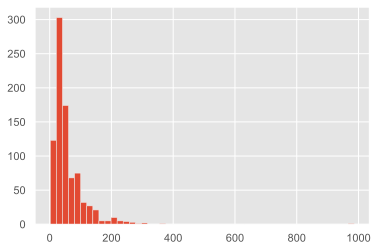

In [9]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [10]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 986


In [11]:
[len(s) for s in sentences].index(maxlen)

538

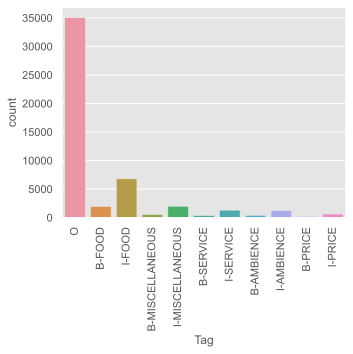

In [12]:
plt.figure(figsize=(5, 5))
ax = sns.countplot('Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

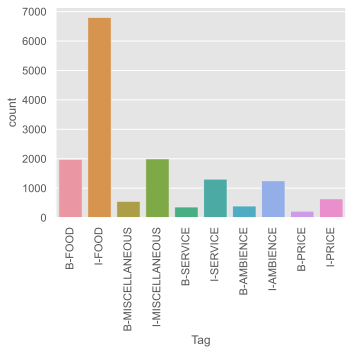

In [13]:
plt.figure(figsize=(5, 5))
ax = sns.countplot('Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Random Forest

In [14]:
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

In [15]:
words = [feature_map(str(w)) for w in data["Word"].values.tolist()]
tags = data["Tag"].values.tolist()

In [16]:
print(words[:5])

[array([0, 1, 0, 4, 0, 1]), array([0, 1, 0, 5, 0, 1]), array([0, 1, 0, 6, 0, 1]), array([0, 1, 0, 4, 0, 1]), array([0, 1, 0, 6, 0, 1])]


In [17]:
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words, y=tags, cv=5)

In [18]:
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=tags)
print(report)

C:\Users\rachm\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

     B-AMBIENCE       0.00      0.00      0.00       392
         B-FOOD       0.00      0.00      0.00      1973
B-MISCELLANEOUS       0.00      0.00      0.00       551
        B-PRICE       0.00      0.00      0.00       217
      B-SERVICE       0.00      0.00      0.00       358
     I-AMBIENCE       0.00      0.00      0.00      1247
         I-FOOD       0.00      0.00      0.00      6799
I-MISCELLANEOUS       0.00      0.00      0.00      1992
        I-PRICE       0.00      0.00      0.00       633
      I-SERVICE       0.00      0.00      0.00      1306
              O       0.69      1.00      0.82     35065

       accuracy                           0.69     50533
      macro avg       0.06      0.09      0.07     50533
   weighted avg       0.48      0.69      0.57     50533



## Conditional Random Fields

In [19]:
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features

In [20]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

In [21]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [22]:
crf = CRF(algorithm='l2sgd',
          # c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [23]:
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

In [24]:
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

                 precision    recall  f1-score   support

     B-AMBIENCE       0.62      0.38      0.47       392
         B-FOOD       0.51      0.29      0.37      1973
B-MISCELLANEOUS       0.27      0.09      0.14       551
        B-PRICE       0.75      0.42      0.54       217
      B-SERVICE       0.66      0.30      0.41       358
     I-AMBIENCE       0.56      0.33      0.42      1247
         I-FOOD       0.61      0.37      0.46      6799
I-MISCELLANEOUS       0.32      0.12      0.18      1992
        I-PRICE       0.77      0.39      0.52       633
      I-SERVICE       0.64      0.31      0.42      1306
              O       0.78      0.94      0.86     35065

       accuracy                           0.75     50533
      macro avg       0.59      0.36      0.43     50533
   weighted avg       0.71      0.75      0.72     50533



## Tuning

In [25]:
crf2 = CRF(algorithm='l2sgd',
          # c1=10,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [26]:
pred = cross_val_predict(estimator=crf2, X=X, y=y, cv=5)
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

                 precision    recall  f1-score   support

     B-AMBIENCE       0.59      0.37      0.46       392
         B-FOOD       0.51      0.28      0.36      1973
B-MISCELLANEOUS       0.23      0.10      0.14       551
        B-PRICE       0.72      0.41      0.53       217
      B-SERVICE       0.61      0.30      0.40       358
     I-AMBIENCE       0.49      0.34      0.40      1247
         I-FOOD       0.61      0.36      0.45      6799
I-MISCELLANEOUS       0.27      0.15      0.20      1992
        I-PRICE       0.72      0.41      0.52       633
      I-SERVICE       0.63      0.34      0.44      1306
              O       0.79      0.93      0.85     35065

       accuracy                           0.74     50533
      macro avg       0.56      0.36      0.43     50533
   weighted avg       0.71      0.74      0.71     50533



In [27]:
crf2.fit(X, y)

CRF(algorithm='l2sgd', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=None, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [28]:
labels = list(crf2.classes_)
labels = list(filter(lambda a: a != 'O', labels))
print(labels)

['B-FOOD', 'I-FOOD', 'B-MISCELLANEOUS', 'I-MISCELLANEOUS', 'B-SERVICE', 'I-SERVICE', 'B-AMBIENCE', 'I-AMBIENCE', 'B-PRICE', 'I-PRICE']


In [29]:
%%time
#Now we will create the Randomized CV search model wherein we will use a modified F1 scorer model considering only the relevant labels
# define fixed parameters and parameters to search
crf3 = CRF(
    algorithm='l2sgd',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    # 'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  9.4min finished
C:\Users\rachm\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 9min 30s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=CRF(algorithm='l2sgd', all_possible_states=None,
                                 all_possible_transitions=False, averaging=None,
                                 c=None, c1=None, c2=0.1,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None,...
                   param_distributions={'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000236AA23CF48>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-FOOD', 'I-FOOD', 'B-M

In [30]:
print('Best parameters:', rs.best_params_)
print('Best CV score:', rs.best_score_)
print('Model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

Best parameters: {'c2': 0.01376908550973692}
Best CV score: 0.42444897216450933
Model size: 2.46M


In [31]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0]))

In [32]:
crf3 = rs.best_estimator_
y_pred = crf3.predict(X)
print(metrics.flat_classification_report(
    y, y_pred, labels=sorted_labels, digits=3))

                 precision    recall  f1-score   support

     B-AMBIENCE      0.913     0.852     0.881       392
     I-AMBIENCE      0.904     0.895     0.899      1247
         B-FOOD      0.852     0.725     0.783      1973
         I-FOOD      0.901     0.754     0.821      6799
B-MISCELLANEOUS      0.807     0.721     0.761       551
I-MISCELLANEOUS      0.835     0.832     0.834      1992
        B-PRICE      0.891     0.908     0.900       217
        I-PRICE      0.937     0.913     0.925       633
      B-SERVICE      0.927     0.846     0.885       358
      I-SERVICE      0.927     0.900     0.913      1306

      micro avg      0.887     0.796     0.839     15468
      macro avg      0.889     0.835     0.860     15468
   weighted avg      0.888     0.796     0.838     15468



In [33]:
crf3.fit(X,y)

CRF(algorithm='l2sgd', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=None, c2=0.01376908550973692,
    calibration_candidates=None, calibration_eta=None,
    calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [34]:
eli5.show_weights(crf3, top=10)

From \ To,O,B-AMBIENCE,I-AMBIENCE,B-FOOD,I-FOOD,B-MISCELLANEOUS,I-MISCELLANEOUS,B-PRICE,I-PRICE,B-SERVICE,I-SERVICE
O,3.051,0.584,-1.242,1.121,-0.304,0.476,-0.108,0.49,-1.093,0.673,-0.933
B-AMBIENCE,-1.877,0.0,6.328,0.0,-0.551,0.561,0.0,0.0,0.11,0.0,0.0
I-AMBIENCE,0.637,0.906,4.931,0.412,-0.885,-0.137,-1.073,-0.415,0.0,0.005,-1.158
B-FOOD,-0.49,0.0,0.393,0.154,6.08,-0.777,-0.495,0.212,-0.249,0.0,0.0
I-FOOD,0.745,0.212,-1.55,0.933,4.3,-0.416,-0.755,-0.045,-1.353,-0.327,-0.859
B-MISCELLANEOUS,-0.101,0.0,0.0,-0.714,0.0,0.0,7.148,0.0,0.063,0.0,0.0
I-MISCELLANEOUS,0.324,-0.228,-1.503,-0.419,-1.19,0.431,5.276,-0.27,-1.305,-0.468,-1.327
B-PRICE,-0.93,0.0,0.0,-0.591,0.0,-0.293,0.0,0.0,6.04,0.023,0.0
I-PRICE,0.503,-0.362,-0.843,0.166,-1.335,-0.554,0.0,0.01,5.212,0.236,-0.518
B-SERVICE,-1.188,0.0,-0.082,0.0,-0.11,0.0,0.0,0.0,0.087,0.0,6.394


In [35]:
i = np.random.randint(0, len(sentences))
print("Kalimat #:",i)
print("{:25}{:15}\t {}".format("Word", "True", "Prediction"))
print("-" *60)
for w, pred in zip(sentences[i], y_pred[i]):
    print("{:25}{:15}\t{}".format(w[0], w[1], pred))

Kalimat #: 538
Word                     True           	 Prediction
------------------------------------------------------------
aku                      O              	O
nginep                   O              	O
di                       O              	O
trans                    O              	O
selama                   O              	O
liburan                  O              	O
di                       O              	O
bandung                  O              	O
ada                      O              	O
pilihan                  O              	O
untuk                    O              	O
breakfast                O              	O
di                       O              	O
lantai                   O              	O
3                        O              	O
atau                     O              	O
18                       O              	O
berhubung                O              	O
aku                      O              	O
pengen                   O              	O
ngerasain  

In [36]:
# Dataset salah tapi prediksi benar
i = 2
print("{:25}{:15}\t {}".format("Word", "True", "Prediction"))
print("-" *60)
for w, pred in zip(sentences[i], y_pred[i]):
    print("{:25}{:15}\t{}".format(w[0], w[1], pred))

Word                     True           	 Prediction
------------------------------------------------------------
martabak                 I-FOOD         	O
ini                      I-FOOD         	O
lokasinya                O              	O
deket                    O              	O
banget                   O              	O
sama                     O              	O
rumahku                  O              	O
rasanya                  B-FOOD         	B-FOOD
enak                     I-FOOD         	I-FOOD
dan                      O              	I-FOOD
ga                       O              	I-FOOD
pernah                   O              	I-FOOD
berubah                  O              	I-FOOD
dari                     O              	O
aku                      O              	O
kecil                    O              	O
bener                    B-FOOD         	B-FOOD
bener                    I-FOOD         	I-FOOD
suka                     I-FOOD         	I-FOOD
sama                    

### Save Model

In [42]:
import joblib
filename = 'crf-sgd.sav'
joblib.dump(crf3, filename)

['crf-sgd.sav']

### Fungsi untuk return prediksi berdasarkan kalimat input

In [38]:
from nltk.tokenize import word_tokenize

In [39]:
def word2features_input(sent, i):
    word = sent[i]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features

In [40]:
def prediksi(sentence):
    symbols = ['.',',','!','?','&','(',')','-','"']
    sentence = word_tokenize(sentence)
    sentence = [w for w in sentence if not w in symbols]
    
    sentence_feature = [word2features_input(sentence, i) for i in range(len(sentence))]
    prediksi = crf3.predict([sentence_feature])
    
#     print(sentence)
#     print(sentence_feature)
#     print(prediksi)
    return sentence, prediksi

In [43]:
input = input()
kalimat, hasil = prediksi(input)
print("{:20}\t{}".format("Word", "Prediction"))
print("-" *40)
for w, pred in zip(kalimat, hasil[0]):
    print("{:20}\t{}".format(w, pred))

Makanannya enak banget
Word                	Prediction
----------------------------------------
Makanannya          	B-FOOD
enak                	I-FOOD
banget              	I-FOOD
